In [1]:
import os,sys,importlib_resources

# add paths
sys.path.append('../data/KWR_data/')
sys.path.append('../data/psKWR_data/')
sys.path.append('../monod/src/monod/')
sys.path.append('../models/')
sys.path.append('../monod/src/monod/models/')
sys.path.append('../psKWR/')
sys.path.append('../')
sys.path.append(importlib_resources.files('nn_toolbox'))

import numpy as np
import time 
import matplotlib.pyplot as plt
# import monod to a certain direct 

import ypred_module as ypm # need for MMNB and random weights
import direct_module as direct # need for direct
import train_conditional as train # need for data loading

from nn_toolbox import get_moments, get_conditional_moments, get_quantile_moments, get_NORM
import cme_toolbox
# import nnNB_module as nnNB_module_new

import monod # need for QV, FQ, KWR, and psKWR

In [2]:
def get_hellinger(p,q):
    p = p.flatten()
    q = q.flatten()
    p_sqrt = np.sqrt(p)
    q_sqrt = np.sqrt(q)
    a = (p_sqrt-q_sqrt)**2
    b = np.sqrt(np.sum(a))
    
    return (1/(np.sqrt(2)))*b

In [3]:
# Figure 2a: Time vs. Hellinger distance
data_set = train.load_data(1,'../data/KWR_data/','256_test_full')

In [4]:
# set up monod models 
fitmodel_qv = cme_toolbox.CMEModel(bio_model='Bursty',seq_model='None',quad_method='quad_vec')
fitmodel_fq = cme_toolbox.CMEModel(bio_model='Bursty',seq_model='None',quad_method='fixed_quad')
fitmodel_KWR = cme_toolbox.CMEModel(bio_model='Bursty',seq_model='None',quad_method='nn_10')
fitmodel_psKWR = cme_toolbox.CMEModel(bio_model='Bursty',seq_model='None',quad_method='nn_microstate')

In [16]:
# store 
timing = {'state_spaces' : np.ones(len(data_set)),
          'QV20' : {'norm' : np.ones(len(data_set)), 'unnorm' : np.ones(len(data_set))},
          'QV10' : {'norm' : np.ones(len(data_set)), 'unnorm' : np.ones(len(data_set))},
          'QV4' : {'norm' : np.ones(len(data_set)), 'unnorm' : np.ones(len(data_set))},
          'QV1' : {'norm' : np.ones(len(data_set)), 'unnorm' : np.ones(len(data_set))},
          'FQ' : {'norm' : np.ones(len(data_set)), 'unnorm' : np.ones(len(data_set))},
          'KWR' : {'norm' : np.ones(len(data_set)), 'unnorm' : np.ones(len(data_set))},
          'psKWR' : {'norm' : np.ones(len(data_set)), 'unnorm' : np.ones(len(data_set))},
          'MMNB' : {'norm' : np.ones(len(data_set)), 'unnorm' : np.ones(len(data_set))},
          'RW' : {'norm' : np.ones(len(data_set)), 'unnorm' : np.ones(len(data_set))},
          'DR' : {'norm' : np.ones(len(data_set)), 'unnorm' : np.ones(len(data_set))}
         }

hellinger = { 'state_spaces' : np.ones(len(data_set)),
          'QV10' : {'norm' : np.ones(len(data_set)), 'unnorm' : np.ones(len(data_set))},
          'QV4' : {'norm' : np.ones(len(data_set)), 'unnorm' : np.ones(len(data_set))},
          'QV1' : {'norm' : np.ones(len(data_set)), 'unnorm' : np.ones(len(data_set))},
          'FQ' : {'norm' : np.ones(len(data_set)), 'unnorm' : np.ones(len(data_set))},
          'KWR' : {'norm' : np.ones(len(data_set)), 'unnorm' : np.ones(len(data_set))},
          'psKWR' : {'norm' : np.ones(len(data_set)), 'unnorm' : np.ones(len(data_set))},
          'MMNB' : {'norm' : np.ones(len(data_set)), 'unnorm' : np.ones(len(data_set))},
          'RW' : {'norm' : np.ones(len(data_set)), 'unnorm' : np.ones(len(data_set))},
          'DR' : {'norm' : np.ones(len(data_set)), 'unnorm' : np.ones(len(data_set))}
         }
    

In [24]:
lim_ = [int(np.max([np.ceil(mu_n+1*std_n),30])),int(np.max([np.ceil(mu_m+1*std_m),30]))]
lim_

[31, 30]

In [26]:
for i in range(256):
    print(i)
    # parameter
    p_ = data_set[i][0]
    
    mu_n,mu_m,var_n,var_m,std_n,std_m,COV = get_moments(10**p_[0],10**p_[1],10**p_[2])
    lim_ = [int(np.max([np.ceil(mu_n+1*std_n),10])),int(np.max([np.ceil(mu_m+1*std_m),10]))]
    ss_ = lim_[0]*lim_[1]
    
    # QV20
    lim_large = [int(np.max([np.ceil(mu_n+20*std_n),10])),int(np.max([np.ceil(mu_m+20*std_m),10]))]
    print(ss_)
    timing['state_spaces'][i] = ss_
    hellinger['state_spaces'][i] = ss_
    t1 = time.time()
    qv20 = fitmodel_qv.eval_model_pss(p_,limits=lim_large)
    t_ = time.time()-t1
    timing['QV20']['unnorm'][i]=t_
    timing['QV20']['norm'][i]=t_/ss_
    
    # QV10
    lim_large = [int(np.max([np.ceil(mu_n+10*std_n),10])),int(np.max([np.ceil(mu_m+10*std_m),10]))]
    t1 = time.time()
    qv10 = fitmodel_qv.eval_model_pss(p_,limits=lim_large)
    t_ = time.time()-t1
    timing['QV10']['unnorm'][i]=t_
    timing['QV10']['norm'][i]=t_/ss_
    hell_ = get_hellinger(qv20[:lim_[0],:lim_[1]],qv10[:lim_[0],:lim_[1]])
    hellinger['QV10']['unnorm'][i]= hell_
    hellinger['QV10']['norm'][i]=hell_/ss_
    
    
    # QV4
    lim_large = [int(np.max([np.ceil(mu_n+4*std_n),10])),int(np.max([np.ceil(mu_m+4*std_m),10]))]
    t1 = time.time()
    qv4 = fitmodel_qv.eval_model_pss(p_,limits=lim_large)
    t_ = time.time()-t1
    timing['QV4']['unnorm'][i]=t_
    timing['QV4']['norm'][i]=t_/ss_
    hell_ = get_hellinger(qv20[:lim_[0],:lim_[1]],qv4[:lim_[0],:lim_[1]])
    hellinger['QV4']['unnorm'][i]= hell_
    hellinger['QV4']['norm'][i]=hell_/ss_
    
    # QV1
    t1 = time.time()
    qv1 = fitmodel_qv.eval_model_pss(p_,limits=lim_)
    t_ = time.time()-t1
    timing['QV1']['unnorm'][i]=t_
    timing['QV1']['norm'][i]=t_/ss_
    hell_ = get_hellinger(qv20[:lim_[0],:lim_[1]],qv1)
    hellinger['QV1']['unnorm'][i]= hell_
    hellinger['QV1']['norm'][i]=hell_/ss_
    
    # FQ
    t1 = time.time()
    fq = fitmodel_fq.eval_model_pss(p_,limits=lim_)
    t_ = time.time()-t1
    timing['FQ']['unnorm'][i]=t_
    timing['FQ']['norm'][i]=t_/ss_
    hell_ = get_hellinger(qv20[:lim_[0],:lim_[1]],fq)
    hellinger['FQ']['unnorm'][i]= hell_
    hellinger['FQ']['norm'][i]=hell_/ss_
    
    # KWR
    t1 = time.time()
    kwr = fitmodel_KWR.eval_model_pss(p_,limits=lim_)
    t_ = time.time()-t1
    timing['KWR']['unnorm'][i]=t_
    timing['KWR']['norm'][i]=t_/ss_
    hell_ = get_hellinger(qv20[:lim_[0],:lim_[1]],kwr)
    hellinger['KWR']['unnorm'][i]= hell_
    hellinger['KWR']['norm'][i]=hell_/ss_
    
    # psKWR
    t1 = time.time()
    pskwr = fitmodel_psKWR.eval_model_pss(p_,limits=lim_)
    t_ = time.time()-t1
    timing['psKWR']['unnorm'][i]=t_
    timing['psKWR']['norm'][i]=t_/ss_
    hell_ = get_hellinger(qv20[:lim_[0],:lim_[1]],pskwr)
    hellinger['psKWR']['unnorm'][i]= hell_
    hellinger['psKWR']['norm'][i]=hell_/ss_
    
    # MMNB
    N,M = np.meshgrid(range(lim_[0]),range(lim_[1]),indexing='ij')
    t1 = time.time()
    mmnb = ypm.approximate_conditional_tensorval(p_,N,M).detach().numpy()
    t_ = time.time()-t1
    timing['MMNB']['unnorm'][i]=t_
    timing['MMNB']['norm'][i]=t_/ss_
    hell_ = get_hellinger(qv20[:lim_[0],:lim_[1]],mmnb)
    hellinger['MMNB']['unnorm'][i]= hell_
    hellinger['MMNB']['norm'][i]=hell_/ss_
    
    
    # RW
    nas_range = np.arange(lim_[0])
    mat_range = np.arange(lim_[1])
    t1 = time.time()
    rw = ypm.get_prob(p_,nas_range,mat_range,rand_weights=True)
    t_ = time.time()-t1
    timing['RW']['unnorm'][i]=t_
    timing['RW']['norm'][i]=t_/ss_
    hell_ = get_hellinger(qv20[:lim_[0],:lim_[1]],rw)
    hellinger['RW']['unnorm'][i]= hell_
    hellinger['RW']['norm'][i]=hell_/ss_
    
    # Direct
    t1 = time.time()
    dr = direct.predict_pmf(p_,lim_[0],lim_[1])
    t_ = time.time()-t1
    timing['DR']['unnorm'][i]=t_
    timing['DR']['norm'][i]=t_/ss_
    hell_ = get_hellinger(qv20[:lim_[0],:lim_[1]],dr)
    hellinger['DR']['unnorm'][i]= hell_
    hellinger['DR']['norm'][i]=hell_/ss_
    

0
288
1
100
2
8788
3
100
4
280
5
1170
6
100
7
100
8
370
9
1185
10
2170
11
3696
12
100
13
361
14
4387
15
1340
16
130
17
5696
18
710
19
130
20
810
21
15232
22
20740
23
270
24
7686
25
15295
26
240
27
100
28
10287
29
110
30
1806
31
1752
32
1280
33
230
34
610
35
2390
36
3072
37
480
38
3289
39
120
40
2340
41
242
42
10146
43
6232
44
11340
45
44370
46
2046
47
110
48
530
49
8687
50
100
51
4680
52
100
53
26901
54
3420
55
410
56
960
57
1316
58
6258
59
100
60
65484
61
110
62
370
63
100
64
2196
65
100
66
14040
67
320
68
230
69
120
70
210
71
1425
72
670
73
410
74
1992
75
22275
76
100
77
100
78
170
79
490
80
100
81
240
82
100
83
1150
84
780
85
360
86
520
87
2376
88
2360
89
540
90
140
91
133650
92
1768
93
23807
94
170
95
1380
96
5580
97
100
98
160
99
2178
100
380
101
4264
102
1420
103
86070
104
5612
105
100
106
100
107
100
108
320
109
100
110
130
111
100
112
59072
113
100
114
140
115
7161
116
100
117
100
118
6912
119
41004
120
600
121
69966
122
120
123
100
124
2030
125
4446
126
100
127
3392
128
420
12

In [28]:
# save!!!! 
import pickle 

with open('./new_hellinger_dict_1std', 'wb') as file:
    pickle.dump(hellinger, file)
    
with open('./new_timing_dict_1std', 'wb') as file:
    pickle.dump(timing, file)




In [8]:
# single microstate timing
microstate_timing = {
          'KWR' : np.ones(len(data_set)),
          'psKWR' : np.ones(len(data_set)),
          'MMNB' : np.ones(len(data_set)),
          'RW' : np.ones(len(data_set)),
          'DR' : np.ones(len(data_set)),
         }


In [9]:
# new microstate timing vs. full grid for 256 parameters

for i in range(256):
  
    lim_ = [int(1),int(1)]
    
    # KWR
    t1 = time.time()
    kwr = fitmodel_KWR.eval_model_pss(p_,limits=lim_)
    t_ = time.time()-t1
    microstate_timing['KWR'][i]=t_
    
    # psKWR
    t1 = time.time()
    pskwr = fitmodel_psKWR.eval_model_pss(p_,limits=lim_)
    t_ = time.time()-t1
    microstate_timing['psKWR'][i]=t_
    
    # MMNB
    N,M = np.meshgrid(range(lim_[0]),range(lim_[1]),indexing='ij')
    t1 = time.time()
    mmnb = ypm.approximate_conditional_tensorval(p_,N,M).detach().numpy()
    t_ = time.time()-t1
    microstate_timing['MMNB'][i]=t_
    
    # RW
    nas_range = np.arange(lim_[0])
    mat_range = np.arange(lim_[1])
    t1 = time.time()
    rw = ypm.get_prob(p_,nas_range,mat_range,rand_weights=True)
    t_ = time.time()-t1
    microstate_timing['RW'][i]=t_

    
    # Direct
    t1 = time.time()
    dr = direct.predict_pmf(p_,lim_[0],lim_[1])
    t_ = time.time()-t1
    microstate_timing['DR'][i]=t_


In [10]:
with open('./new_microstate_timing_dict', 'wb') as file:
    pickle.dump(microstate_timing, file)

In [11]:
def plot_cdf(array,label):
    array = np.sort(array)
    plt.plot(array,np.arange(len(array))/len(array),label=label)

/var/folders/yr/5f4ybhp15cv9yg_9r00sy7880000gn/T/ipykernel_45128/973923386.py:7: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0,10**13)


(1.6670889196172893e-07, 10000000000000)

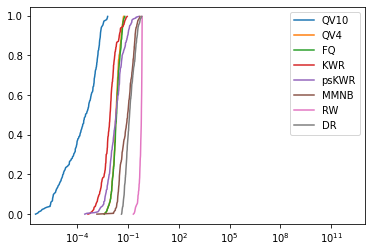

In [12]:
for key in list(timing.keys())[2:]:
    
    plot_cdf(hellinger[key]['unnorm'],label=key)

plt.legend()
plt.xscale('log')
plt.xlim(0,10**13)

In [13]:
timing['FQ']['unnorm']

array([4.26483154e-03, 2.03132629e-04, 3.09078693e-02, 2.00986862e-04,
       2.18868256e-04, 4.73737717e-04, 2.12907791e-04, 2.12907791e-04,
       5.91754913e-04, 2.35390663e-03, 6.47068024e-04, 3.69095802e-03,
       1.85012817e-04, 8.14199448e-04, 1.00879669e-02, 9.74178314e-04,
       3.24249268e-04, 8.15582275e-03, 3.13043594e-04, 3.85046005e-04,
       6.24179840e-04, 1.84288025e-02, 2.60181427e-02, 2.44855881e-04,
       8.05473328e-03, 9.28781033e-02, 2.08139420e-04, 1.70946121e-04,
       4.64661121e-02, 3.93867493e-04, 4.59194183e-03, 5.85484505e-03,
       1.13606453e-03, 5.69105148e-04, 1.34587288e-03, 3.55792046e-03,
       7.07697868e-03, 2.80141830e-04, 8.45432281e-03, 3.05175781e-04,
       5.43808937e-03, 4.52756882e-04, 1.66442394e-02, 4.53393459e-02,
       1.27730370e-02, 2.84673929e-01, 4.49395180e-03, 3.01122665e-04,
       7.72953033e-04, 4.12299633e-02, 3.75032425e-04, 4.38189507e-03,
       1.74760818e-04, 1.10594273e-01, 7.80892372e-03, 5.56945801e-04,
      